In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import requests
import zipfile
import os

In [2]:
np.random.seed(42)


In [3]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(np.clip(x, -500, 500))

def clip_gradients(grads, max_norm=5.0):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    if total_norm > max_norm:
        clip_coeff = max_norm / (total_norm + 1e-6)
        for i in range(len(grads)):
            grads[i] *= clip_coeff
    return grads

In [5]:
class LSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        scale = np.sqrt(2.0 / (input_size + hidden_size))

        self.Wf = np.random.normal(0, scale, (hidden_size, input_size + hidden_size))
        self.bf = np.zeros((hidden_size, 1))

        self.Wi = np.random.normal(0, scale, (hidden_size, input_size + hidden_size))
        self.bi = np.zeros((hidden_size, 1))

        self.Wc = np.random.normal(0, scale, (hidden_size, input_size + hidden_size))
        self.bc = np.zeros((hidden_size, 1))

        self.Wo = np.random.normal(0, scale, (hidden_size, input_size + hidden_size))
        self.bo = np.zeros((hidden_size, 1))

        self.reset_gradients()

    def reset_gradients(self):
        self.dWf = np.zeros_like(self.Wf)
        self.dbf = np.zeros_like(self.bf)
        self.dWi = np.zeros_like(self.Wi)
        self.dbi = np.zeros_like(self.bi)
        self.dWc = np.zeros_like(self.Wc)
        self.dbc = np.zeros_like(self.bc)
        self.dWo = np.zeros_like(self.Wo)
        self.dbo = np.zeros_like(self.bo)

    def forward(self, x, h_prev, c_prev):
        self.x = x
        self.h_prev = h_prev
        self.c_prev = c_prev

        concat = np.vstack((h_prev, x))
        self.concat = concat

        self.f_gate = sigmoid(np.dot(self.Wf, concat) + self.bf)
        self.i_gate = sigmoid(np.dot(self.Wi, concat) + self.bi)
        self.c_candidate = tanh(np.dot(self.Wc, concat) + self.bc)
        self.o_gate = sigmoid(np.dot(self.Wo, concat) + self.bo)

        self.c = self.f_gate * c_prev + self.i_gate * self.c_candidate
        self.c_tanh = tanh(self.c)
        self.h = self.o_gate * self.c_tanh

        return self.h, self.c

    def backward(self, dh, dc):
        do = dh * self.c_tanh
        dc += dh * self.o_gate * (1 - self.c_tanh**2)

        dc_candidate = dc * self.i_gate
        di = dc * self.c_candidate
        df = dc * self.c_prev
        dc_prev = dc * self.f_gate

        do_input = do * self.o_gate * (1 - self.o_gate)
        dc_candidate_input = dc_candidate * (1 - self.c_candidate**2)
        di_input = di * self.i_gate * (1 - self.i_gate)
        df_input = df * self.f_gate * (1 - self.f_gate)

        self.dWo += np.dot(do_input, self.concat.T)
        self.dbo += do_input
        self.dWc += np.dot(dc_candidate_input, self.concat.T)
        self.dbc += dc_candidate_input
        self.dWi += np.dot(di_input, self.concat.T)
        self.dbi += di_input
        self.dWf += np.dot(df_input, self.concat.T)
        self.dbf += df_input

        dconcat = (np.dot(self.Wf.T, df_input) +
                  np.dot(self.Wi.T, di_input) +
                  np.dot(self.Wc.T, dc_candidate_input) +
                  np.dot(self.Wo.T, do_input))

        dh_prev = dconcat[:self.hidden_size]
        dx = dconcat[self.hidden_size:]

        return dx, dh_prev, dc_prev

In [6]:
class LSTMModel:
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = np.random.normal(0, 0.1, (vocab_size, embedding_dim))
        self.lstm_cell = LSTMCell(embedding_dim, hidden_size)

        self.Wy = np.random.normal(0, np.sqrt(2.0/hidden_size), (output_size, hidden_size))
        self.by = np.zeros((output_size, 1))

        self.reset_gradients()

    def reset_gradients(self):
        self.dembedding = np.zeros_like(self.embedding)
        self.dWy = np.zeros_like(self.Wy)
        self.dby = np.zeros_like(self.by)
        self.lstm_cell.reset_gradients()

    def forward(self, inputs):
        seq_len = len(inputs)
        h = np.zeros((self.hidden_size, 1))
        c = np.zeros((self.hidden_size, 1))

        self.inputs = inputs
        self.hs = {}
        self.cs = {}
        self.xs = {}

        for t in range(seq_len):
            if inputs[t] < self.vocab_size:
                x = self.embedding[inputs[t]].reshape(-1, 1)
            else:
                x = np.zeros((self.embedding_dim, 1))

            self.xs[t] = x
            h, c = self.lstm_cell.forward(x, h, c)
            self.hs[t] = h
            self.cs[t] = c

        y = np.dot(self.Wy, h) + self.by
        self.output = sigmoid(y)

        return self.output

    def backward(self, target):
        seq_len = len(self.inputs)

        dpred = self.output - target

        self.dWy += np.dot(dpred, self.hs[seq_len-1].T)
        self.dby += dpred

        dh = np.dot(self.Wy.T, dpred)
        dc = np.zeros((self.hidden_size, 1))

        for t in reversed(range(seq_len)):
            dx, dh, dc = self.lstm_cell.backward(dh, dc)
            if self.inputs[t] < self.vocab_size:
                self.dembedding[self.inputs[t]] += dx.flatten()

    def update_params(self, learning_rate, batch_size):
        all_grads = [
            self.dembedding, self.dWy, self.dby,
            self.lstm_cell.dWf, self.lstm_cell.dbf,
            self.lstm_cell.dWi, self.lstm_cell.dbi,
            self.lstm_cell.dWc, self.lstm_cell.dbc,
            self.lstm_cell.dWo, self.lstm_cell.dbo
        ]

        for grad in all_grads:
            grad /= batch_size

        clip_gradients(all_grads, max_norm=5.0)

        self.embedding -= learning_rate * self.dembedding
        self.Wy -= learning_rate * self.dWy
        self.by -= learning_rate * self.dby

        self.lstm_cell.Wf -= learning_rate * self.lstm_cell.dWf
        self.lstm_cell.bf -= learning_rate * self.lstm_cell.dbf
        self.lstm_cell.Wi -= learning_rate * self.lstm_cell.dWi
        self.lstm_cell.bi -= learning_rate * self.lstm_cell.dbi
        self.lstm_cell.Wc -= learning_rate * self.lstm_cell.dWc
        self.lstm_cell.bc -= learning_rate * self.lstm_cell.dbc
        self.lstm_cell.Wo -= learning_rate * self.lstm_cell.dWo
        self.lstm_cell.bo -= learning_rate * self.lstm_cell.dbo

        self.reset_gradients()

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.split()

In [8]:
def create_dataset():
    positive_reviews = [
        "this movie is absolutely fantastic and amazing",
        "i love this film it is wonderful and great",
        "excellent movie with great acting and story",
        "brilliant performance by all actors superb",
        "outstanding film with incredible cinematography",
        "amazing storyline and perfect execution brilliant",
        "wonderful movie that touched my heart deeply",
        "fantastic acting and beautiful direction superb",
        "incredible movie with stunning visuals amazing",
        "perfect film with excellent screenplay wonderful"
    ] * 100

    negative_reviews = [
        "this movie is terrible and boring completely awful",
        "i hate this film it is horrible and bad",
        "worst movie with terrible acting and story",
        "awful performance by all actors terrible",
        "disappointing film with poor cinematography",
        "boring storyline and bad execution terrible",
        "terrible movie that wasted my time awful",
        "bad acting and poor direction horrible",
        "awful movie with horrible visuals terrible",
        "worst film with terrible screenplay boring"
    ] * 100

    reviews = positive_reviews + negative_reviews
    labels = [1] * len(positive_reviews) + [0] * len(negative_reviews)

    combined = list(zip(reviews, labels))
    np.random.shuffle(combined)
    reviews, labels = zip(*combined)

    return list(reviews), list(labels)

In [9]:
print("Creating dataset...")
reviews, labels = create_dataset()
processed_reviews = [preprocess_text(review) for review in reviews]

print("Building vocabulary...")
all_words = []
for review in processed_reviews:
    all_words.extend(review)

Creating dataset...
Building vocabulary...


In [10]:
word_counts = Counter(all_words)
vocab = ['<PAD>', '<UNK>'] + [word for word, count in word_counts.most_common(1000)]
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

In [11]:
def text_to_sequence(text, word_to_idx, max_len=15):
    sequence = []
    words = text[:max_len] if len(text) > max_len else text
    for word in words:
        if word in word_to_idx:
            sequence.append(word_to_idx[word])
        else:
            sequence.append(word_to_idx['<UNK>'])

    while len(sequence) < max_len:
        sequence.append(word_to_idx['<PAD>'])

    return sequence


In [12]:
max_sequence_length = 15
X = [text_to_sequence(review, word_to_idx, max_sequence_length) for review in processed_reviews]
y = labels


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset created: {len(X_train)} training samples, {len(X_test)} test samples")
print(f"Vocabulary size: {len(vocab)}")

Dataset created: 1600 training samples, 400 test samples
Vocabulary size: 53


In [14]:
vocab_size = len(vocab)
embedding_dim = 32
hidden_size = 32
output_size = 1

In [15]:
model = LSTMModel(vocab_size, embedding_dim, hidden_size, output_size)

In [16]:
def compute_loss(pred, target):
    pred = np.clip(pred, 1e-7, 1 - 1e-7)
    return -target * np.log(pred) - (1 - target) * np.log(1 - pred)

def compute_accuracy(predictions, targets):
    pred_labels = (predictions > 0.5).astype(int)
    return np.mean(pred_labels == targets)

In [17]:
epochs = 70
learning_rate = 0.1
batch_size = 32

In [18]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [20]:
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_predictions = []
    epoch_train_targets = []

    indices = np.random.permutation(len(X_train))

    for i in range(0, len(X_train), batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_loss = 0

        for idx in batch_indices:
            x_seq = X_train[idx]
            target = np.array([[y_train[idx]]]).reshape(-1, 1)

            pred = model.forward(x_seq)
            loss = compute_loss(pred, target)

            batch_loss += loss.item()
            epoch_train_predictions.append(pred.item())
            epoch_train_targets.append(target.item())

            model.backward(target)

        model.update_params(learning_rate, len(batch_indices))
        epoch_train_loss += batch_loss

    avg_train_loss = epoch_train_loss / len(X_train)
    avg_train_acc = compute_accuracy(np.array(epoch_train_predictions), np.array(epoch_train_targets))

    test_predictions = []
    test_loss = 0
    for x_seq, target in zip(X_test, y_test):
        pred = model.forward(x_seq)
        loss = compute_loss(pred, np.array([[target]]))
        test_loss += loss.item()
        test_predictions.append(pred.item())

    avg_test_loss = test_loss / len(X_test)
    avg_test_acc = compute_accuracy(np.array(test_predictions), np.array(y_test))

    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    test_losses.append(avg_test_loss)
    test_accuracies.append(avg_test_acc)

    if epoch % 5 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1:2d}/{epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | Test Loss: {avg_test_loss:.4f} | Test Acc: {avg_test_acc:.4f}")

    if epoch > 10 and avg_train_acc > 0.7:
        learning_rate *= 0.95


Epoch  1/70 | Train Loss: 0.6948 | Train Acc: 0.4906 | Test Loss: 0.6927 | Test Acc: 0.5075
Epoch  6/70 | Train Loss: 0.6934 | Train Acc: 0.4994 | Test Loss: 0.6932 | Test Acc: 0.4925
Epoch 11/70 | Train Loss: 0.6931 | Train Acc: 0.5050 | Test Loss: 0.6925 | Test Acc: 0.4925
Epoch 16/70 | Train Loss: 0.6924 | Train Acc: 0.5231 | Test Loss: 0.6926 | Test Acc: 0.4925
Epoch 21/70 | Train Loss: 0.6915 | Train Acc: 0.5375 | Test Loss: 0.6902 | Test Acc: 0.5075
Epoch 26/70 | Train Loss: 0.6830 | Train Acc: 0.6306 | Test Loss: 0.6758 | Test Acc: 0.5075
Epoch 31/70 | Train Loss: 0.6084 | Train Acc: 0.6844 | Test Loss: 0.7000 | Test Acc: 0.4925
Epoch 36/70 | Train Loss: 0.0138 | Train Acc: 1.0000 | Test Loss: 0.0118 | Test Acc: 1.0000
Epoch 41/70 | Train Loss: 0.0055 | Train Acc: 1.0000 | Test Loss: 0.0052 | Test Acc: 1.0000
Epoch 46/70 | Train Loss: 0.0037 | Train Acc: 1.0000 | Test Loss: 0.0035 | Test Acc: 1.0000
Epoch 51/70 | Train Loss: 0.0029 | Train Acc: 1.0000 | Test Loss: 0.0028 | Test 

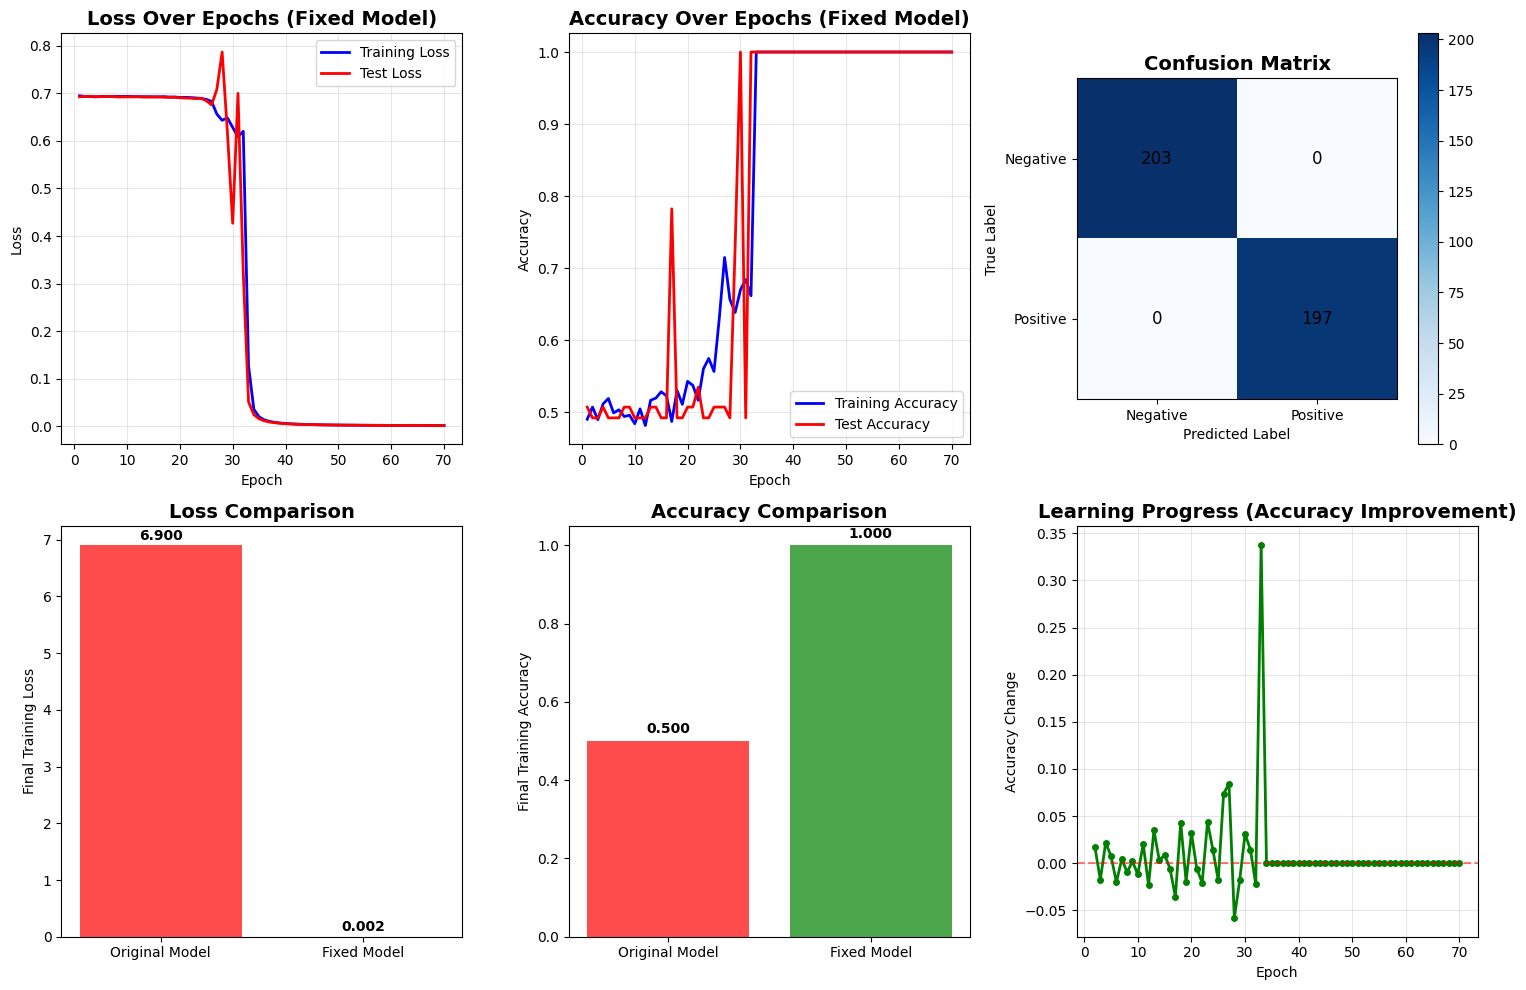

In [21]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(range(1, epochs+1), test_losses, 'r-', label='Test Loss', linewidth=2)
plt.title('Loss Over Epochs (Fixed Model)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(range(1, epochs+1), train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(range(1, epochs+1), test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
plt.title('Accuracy Over Epochs (Fixed Model)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
final_predictions = []
for x_seq in X_test:
    pred = model.forward(x_seq)
    final_predictions.append(pred.item())

predicted_labels = (np.array(final_predictions) > 0.5).astype(int)
confusion_matrix = np.zeros((2, 2))
for true_label, pred_label in zip(y_test, predicted_labels):
    confusion_matrix[true_label][pred_label] += 1

plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

for i in range(2):
    for j in range(2):
        plt.text(j, i, int(confusion_matrix[i, j]), ha="center", va="center", fontsize=12)

plt.subplot(2, 3, 4)
loss_comparison = plt.bar(['Original Model', 'Fixed Model'], [6.9, train_losses[-1]],
                         color=['red', 'green'], alpha=0.7)
plt.title('Loss Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Final Training Loss')
for i, v in enumerate([6.9, train_losses[-1]]):
    plt.text(i, v + 0.1, f'{v:.3f}', ha='center', fontweight='bold')

plt.subplot(2, 3, 5)
acc_comparison = plt.bar(['Original Model', 'Fixed Model'], [0.5, train_accuracies[-1]],
                        color=['red', 'green'], alpha=0.7)
plt.title('Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Final Training Accuracy')
for i, v in enumerate([0.5, train_accuracies[-1]]):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.subplot(2, 3, 6)
epoch_improvement = np.diff(train_accuracies)
plt.plot(range(2, epochs+1), epoch_improvement, 'g-', linewidth=2, marker='o', markersize=4)
plt.title('Learning Progress (Accuracy Improvement)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Change')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [22]:
print("\n" + "="*60)
print("FIXED LSTM RESULTS")
print("="*60)
print(f"Final Training Loss: {train_losses[-1]:.4f} (vs Original: 6.9)")
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f} (vs Original: 0.5)")
print(f"Final Test Loss: {test_losses[-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")
print(f"Loss Improvement: {((6.9 - train_losses[-1])/6.9)*100:.1f}%")
print(f"Accuracy Improvement: {((train_accuracies[-1] - 0.5)/0.5)*100:.1f}%")
print("="*60)

def predict_sentiment(text, model, word_to_idx, max_len=15):
    processed = preprocess_text(text)
    sequence = text_to_sequence(processed, word_to_idx, max_len)
    prediction = model.forward(sequence)
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction.item() if prediction > 0.5 else 1 - prediction.item()
    return sentiment, confidence

test_sentences = [
    "This movie is absolutely wonderful and fantastic amazing",
    "I hate this terrible and boring awful film",
    "Great acting and amazing story brilliant",
    "Worst movie ever made terrible horrible"
]

print("\nSample Predictions with Fixed Model:")
print("-" * 50)
for sentence in test_sentences:
    sentiment, confidence = predict_sentiment(sentence, model, word_to_idx)
    print(f"Text: '{sentence}'")
    print(f"Predicted: {sentiment} (Confidence: {confidence:.4f})")
    print("-" * 50)


FIXED LSTM RESULTS
Final Training Loss: 0.0019 (vs Original: 6.9)
Final Training Accuracy: 1.0000 (vs Original: 0.5)
Final Test Loss: 0.0019
Final Test Accuracy: 1.0000
Loss Improvement: 100.0%
Accuracy Improvement: 100.0%

Sample Predictions with Fixed Model:
--------------------------------------------------
Text: 'This movie is absolutely wonderful and fantastic amazing'
Predicted: Positive (Confidence: 0.9976)
--------------------------------------------------
Text: 'I hate this terrible and boring awful film'
Predicted: Negative (Confidence: 0.9986)
--------------------------------------------------
Text: 'Great acting and amazing story brilliant'
Predicted: Positive (Confidence: 0.9978)
--------------------------------------------------
Text: 'Worst movie ever made terrible horrible'
Predicted: Negative (Confidence: 0.9987)
--------------------------------------------------
